## FCN全连接网络

In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
%matplotlib inline

!pip -V

2023-08-21 15:42:41.664450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 15:42:42.482207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


pip 23.2.1 from /home/jhr/anaconda3/envs/yolo/lib/python3.11/site-packages/pip (python 3.11)


In [10]:
# os.listdir(
#     "/home/jhr/Documents/data/location/annotations1/annotations/trimaps")[:1]
# img = tf.io.read_file(
#     "/home/jhr/Documents/data/location/annotations1/annotations/trimaps/leonberger_24.png")
# img = tf.image.decode_png(img)
# plt.imshow(img)
# img.shape
# img = tf.squeeze(img)  # 降维度
# img.shape
# plt.imshow(img)
# img2 = tf.io.read_file(
#     "/home/jhr/Documents/data/location/images1/images/leonberger_24.jpg")
# img2 = tf.image.decode_jpeg(img2)
# # plt.imshow(img2)

## 读取图片

In [2]:
images = glob.glob(
    #     'C:/Users/yeolume/source/data/图片定位与分割数据集/images/*.jpg')
    '/home/jhr/Documents/data/location/images1/images/*.jpg')
images.sort(key=lambda x: x.split('/')[-1].split('.jpg')[0])  # 排序
images[:5]

['/home/jhr/Documents/data/location/images1/images/Abyssinian_1.jpg',
 '/home/jhr/Documents/data/location/images1/images/Abyssinian_10.jpg',
 '/home/jhr/Documents/data/location/images1/images/Abyssinian_100.jpg',
 '/home/jhr/Documents/data/location/images1/images/Abyssinian_101.jpg',
 '/home/jhr/Documents/data/location/images1/images/Abyssinian_102.jpg']

In [3]:
anno = glob.glob(
    # 'C:/Users/yeolume/source/data/图片定位与分割数据集/annotations/trimaps/*.png')
    '/home/jhr/Documents/data/location/annotations1/annotations/trimaps/*.png')
anno.sort(key=lambda x: x.split('/')[-1].split('.png')[0])
anno[:5]

['/home/jhr/Documents/data/location/annotations1/annotations/trimaps/Abyssinian_1.png',
 '/home/jhr/Documents/data/location/annotations1/annotations/trimaps/Abyssinian_10.png',
 '/home/jhr/Documents/data/location/annotations1/annotations/trimaps/Abyssinian_100.png',
 '/home/jhr/Documents/data/location/annotations1/annotations/trimaps/Abyssinian_101.png',
 '/home/jhr/Documents/data/location/annotations1/annotations/trimaps/Abyssinian_102.png']

**乱序**

In [4]:
np.random.seed(2019)
index = np.random.permutation(len(images))

images = np.array(images)[index]
anno = np.array(anno)[index]
images[:1], anno[:1]

(array(['/home/jhr/Documents/data/location/images1/images/newfoundland_22.jpg'],
       dtype='<U83'),
 array(['/home/jhr/Documents/data/location/annotations1/annotations/trimaps/newfoundland_22.png'],
       dtype='<U101'))

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((images, anno))

2023-08-21 15:42:49.505691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9583 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
2023-08-21 15:42:49.506428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9625 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5


In [6]:
test_count = int(len(images) * 0.2)
train_count = len(images) - test_count

test_count, train_count

(1478, 5912)

In [7]:
data_train = dataset.skip(test_count)
data_test = dataset.skip(train_count)

In [8]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [9]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

In [10]:
def normal_img(input_images, input_anno):
    input_images = tf.cast(input_images, tf.float32)
    input_images = input_images / 127.5 - 1

    input_anno -= 1
    return input_images, input_anno

In [11]:
@tf.function
def load_images(input_images_path, input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    input_image = tf.image.resize(input_image, (224, 224))
    input_anno = tf.image.resize(input_anno, (224, 224))
    return normal_img(input_image, input_anno)

**创建训练数据与测试数据**

In [12]:
data_train = data_train.map(load_images,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE
                            )

data_test = data_test.map(load_images,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE
                          )

In [13]:
batch_size_per_replica = 64  #单卡batch数量
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: %d' % strategy.num_replicas_in_sync)  # 輸出設備數量
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync  #输出总batch

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [14]:
BATCH_SIZE = batch_size
data_train = data_train.repeat().shuffle(100).batch(BATCH_SIZE)
data_test = data_test.batch(BATCH_SIZE)

绘制图片

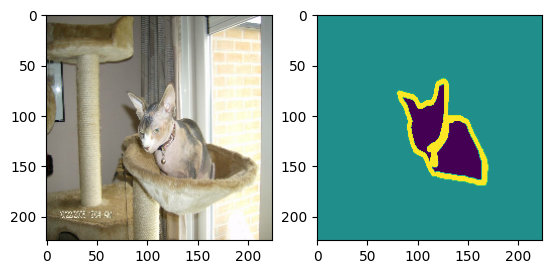

In [15]:
for img, anno in data_train.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[0]))

**以下为单卡训练**

创建网络

In [ ]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        input_shape=(224, 224, 3),
                                        include_top=False
                                        )

In [ ]:
# conv_base.summary()

In [ ]:
# conv_base.get_layer('block5_conv3').output

In [ ]:
# sub_model = tf.keras.models.Model(inputs=conv_base.input,
#                                   outputs=conv_base.get_layer('block5_conv3').output
#                                  )

In [ ]:
# sub_model.summary()

**创建多输出模型**

In [ ]:
layer_names = [
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
    'block5_pool'
]

layers_output = [conv_base.get_layer(
    layer_name).output for layer_name in layer_names]

In [ ]:
multi_out_model = tf.keras.models.Model(inputs=conv_base.input,
                                        outputs=layers_output
                                        )

In [ ]:
multi_out_model.trainable = False

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
out_block5_conv3, out_block4_conv3, out_block3_conv3, out = multi_out_model(
    inputs)

In [ ]:
# 对out做上采样
x1 = tf.keras.layers.Conv2DTranspose(512, 3,
                                     strides=2,
                                     padding='same',
                                     activation='relu'
                                     )(out)
# 增加一层卷积，提高特征识别
x1 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x1)

In [ ]:
x1.shape

In [ ]:
x2 = tf.add(x1, out_block5_conv3)
# 对x2做上采样
x2 = tf.keras.layers.Conv2DTranspose(512, 3,
                                     strides=2,
                                     padding='same',
                                     activation='relu'
                                     )(x2)
# 增加一层卷积，提高特征识别
x2 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x2)

In [ ]:
x2.shape

In [ ]:
x3 = tf.add(x2, out_block4_conv3)
# 对x3做上采样
x3 = tf.keras.layers.Conv2DTranspose(256, 3,
                                     strides=2,
                                     padding='same',
                                     activation='relu'
                                     )(x3)
# 增加一层卷积，提高特征识别
x3 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x3)

In [ ]:
x3.shape

In [ ]:
x4 = tf.add(x3, out_block3_conv3)
# 对x4做上采样
x5 = tf.keras.layers.Conv2DTranspose(128, 3,
                                     strides=2,
                                     padding='same',
                                     activation='relu'
                                     )(x4)
# 增加一层卷积，提高特征识别
x5 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x5)

In [ ]:
x5.shape

In [ ]:
prediction = tf.keras.layers.Conv2DTranspose(3, 3,
                                             strides=2,
                                             padding='same',
                                             activation='softmax'
                                             )(x5)

In [ ]:
prediction.shape

In [ ]:
model = tf.keras.models.Model(
    inputs=inputs,
    outputs=prediction
)

In [ ]:
# model.summary()

**单机多卡**

In [23]:
with strategy.scope():
    conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                            input_shape=(224, 224, 3),
                                            include_top=False)

    layer_names = [
        'block5_conv3',
        'block4_conv3',
        'block3_conv3',
        'block5_pool'
    ]

    layers_output = [conv_base.get_layer(
        layer_name).output for layer_name in layer_names]

    multi_out_model = tf.keras.models.Model(inputs=conv_base.input,
                                            outputs=layers_output
                                            )
    multi_out_model.trainable = True
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    out_block5_conv3, out_block4_conv3, out_block3_conv3, out = multi_out_model(
        inputs)

    # 对out做上采样
    x1 = tf.keras.layers.Conv2DTranspose(512, 3,
                                         strides=2,
                                         padding='same',
                                         activation='relu'
                                         )(out)
    # 增加一层卷积，提高特征识别
    x1 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x1)

    x2 = tf.add(x1, out_block5_conv3)
    # 对x2做上采样
    x2 = tf.keras.layers.Conv2DTranspose(512, 3,
                                         strides=2,
                                         padding='same',
                                         activation='relu'
                                         )(x2)
    # 增加一层卷积，提高特征识别
    x2 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x2)

    x3 = tf.add(x2, out_block4_conv3)
    # 对x3做上采样
    x3 = tf.keras.layers.Conv2DTranspose(256, 3,
                                         strides=2,
                                         padding='same',
                                         activation='relu'
                                         )(x3)
    # 增加一层卷积，提高特征识别
    x3 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x3)

    x4 = tf.add(x3, out_block3_conv3)
    # 对x4做上采样
    x5 = tf.keras.layers.Conv2DTranspose(128, 3,
                                         strides=2,
                                         padding='same',
                                         activation='relu'
                                         )(x4)
    # 增加一层卷积，提高特征识别
    x5 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x5)

    prediction = tf.keras.layers.Conv2DTranspose(3, 3,
                                                 strides=2,
                                                 padding='same',
                                                 activation='softmax'
                                                 )(x5)

    #创建模型
    model = tf.keras.models.Model(
        inputs=inputs,
        outputs=prediction
    )

In [24]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        [(None, 14, 14, 512),        1471468   ['input_4[0][0]']             
                              (None, 28, 28, 512),        8                                       
                              (None, 56, 56, 256),                                                
                              (None, 7, 7, 512)]                                                  
                                                                                                  
 conv2d_transpose_5 (Conv2D  (None, 14, 14, 512)          2359808   ['model_2[0][3]']       

**配置模型**

In [25]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

**训练模型**

In [26]:
lr_reduce = keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.8, min_lr=0.00000001)

In [27]:
history = model.fit(data_train,
                    epochs=100,
                    steps_per_epoch=train_count // BATCH_SIZE,
                    validation_data=data_test,
                    validation_steps=test_count // BATCH_SIZE,
                    callbacks=[lr_reduce]
                    )

46/46 [==============================] - 46s 703ms/step - loss: 0.8824 - acc: 0.5644 - val_loss: 0.7362 - val_acc: 0.5827 - lr: 0.0010
Epoch 2/100
46/46 [==============================] - 33s 722ms/step - loss: 0.6687 - acc: 0.6997 - val_loss: 0.5773 - val_acc: 0.7505 - lr: 0.0010
Epoch 3/100
46/46 [==============================] - 33s 728ms/step - loss: 0.5379 - acc: 0.7715 - val_loss: 0.4521 - val_acc: 0.8145 - lr: 0.0010
Epoch 4/100
46/46 [==============================] - 34s 731ms/step - loss: 0.4964 - acc: 0.7953 - val_loss: 0.4049 - val_acc: 0.8339 - lr: 0.0010
Epoch 5/100
46/46 [==============================] - 33s 728ms/step - loss: 0.3862 - acc: 0.8433 - val_loss: 0.3648 - val_acc: 0.8516 - lr: 0.0010
Epoch 6/100
46/46 [==============================] - 33s 728ms/step - loss: 0.4669 - acc: 0.8159 - val_loss: 0.4661 - val_acc: 0.8117 - lr: 0.0010
Epoch 7/100
46/46 [==============================] - 33s 727ms/step - loss: 0.3934 - acc: 0.8411 - val_loss: 0.3305 - val_acc: 0.8

KeyboardInterrupt: 

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.epoch, history.history.get('acc'), label='acc', color='b')
plt.plot(history.epoch, history.history.get(
    'val_acc'), label='val_acc', color='r')

In [ ]:
num = 3
for img, mask in data_train.take(1):
    out_img = model.predict(img)
    out_img = tf.argmax(out_img, axis=-1)
    out_img = out_img[..., tf.newaxis]

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i * num + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.subplot(num, 3, i * num + 2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i * num + 3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(out_img[i]))

In [ ]:
model.save('segmentation_v1.h5')

**tesging**

In [2]:
#加载模型
new_model = tf.keras.models.load_model('/home/jhr/Documents/segmentation_v1.h5')

In [3]:
num = 3
for img, mask in data_train.take(1):
    out_img = new_model.predict(img)
    out_img = tf.argmax(out_img, axis=-1)
    out_img = out_img[..., tf.newaxis]

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i * num + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.subplot(num, 3, i * num + 2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i * num + 3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(out_img[i]))

NameError: name 'data_train' is not defined

In [23]:
img.shape

TensorShape([64, 224, 224, 3])

In [20]:
# new_model.summary()